In [1]:
import os
import random as rn
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import *

%matplotlib inline

In [2]:
file = open('../utils/envs', 'r')
lines = file.readlines()

repo_dir = seed = None
for line in lines:
       if 'LRDIR' in line:
           repo_dir = line.split('=')[-1]
       elif 'PYTHONHASHSEED' in line:
           seed = line.split('=')[-1]

os.environ['LRDIR'] = repo_dir
os.environ['PYTHONHASHSEED'] = seed

from utils import global_params
from utils.keras_video_datagen import ImageDataGenerator

rn.seed(global_params.rn_seed)
np.random.seed(global_params.np_random_seed)
tf.random.set_seed(global_params.tf_random)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
datagen = ImageDataGenerator()
val_data = datagen.flow_from_directory(os.path.join(global_params.repo_dir[:-1], "lip_reading/data/validation"),
                                       target_size=(global_params.img_h, global_params.img_w),
                                       batch_size=1,
                                       frames_per_step=global_params.frames_n, shuffle=False, seed=None,
                                       color_mode='rgb')
filenames = val_data.filenames
nb_samples = len(filenames)

val_classes = []
for i in list(range(0, int(len(val_data.classes)), global_params.frames_n)):
    val_classes.append(int(np.mean(np.array(val_data.classes[i:i + global_params.frames_n]))))

target_names = global_params.classes

Shuffle: False
Seed: None
Found 4400 images belonging to 10 classes.


In [5]:
ln = load_model(os.path.join(global_params.repo_dir[:-1],
                             "lip_reading/models/results/norm/norm_4e-3_272_1.8118_0.6450"))

In [6]:
prediction = ln.predict(val_data, steps=ceil(nb_samples / global_params.frames_n), verbose=1)
pred_classes = prediction.argmax(axis=-1)

200/200 [==============================] - 8s 42ms/step

Text(0.5, 0.98, 'SGD(lr=4e-3, momentum=0.90, nesterov=True)\n    loss: 1.4656 - acc: 0.9969 - val_loss: 1.8118 - val_acc: 0.6450')

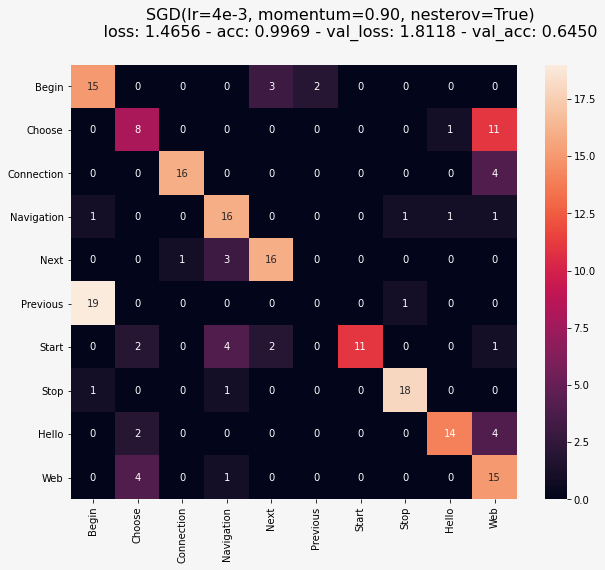

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))

array = confusion_matrix(val_classes, pred_classes)

df_cm = pd.DataFrame(array, index=[i for i in target_names],
                     columns=[i for i in target_names])

ax1 = sn.heatmap(df_cm, annot=True)
fig.set_facecolor("#F6F6F6")
fig.suptitle((
    'SGD(lr=4e-3, momentum=0.90, nesterov=True)\n\
    loss: 1.4656 - acc: 0.9969 - val_loss: 1.8118 - val_acc: 0.6450'), fontsize=16, color='Black')

# plt.savefig('matrix.png')

In [8]:
print(classification_report(val_classes, pred_classes, target_names=target_names))

              precision    recall  f1-score   support

       Begin       0.42      0.75      0.54        20
      Choose       0.50      0.40      0.44        20
  Connection       0.94      0.80      0.86        20
  Navigation       0.64      0.80      0.71        20
        Next       0.76      0.80      0.78        20
    Previous       0.00      0.00      0.00        20
       Start       1.00      0.55      0.71        20
        Stop       0.90      0.90      0.90        20
       Hello       0.88      0.70      0.78        20
         Web       0.42      0.75      0.54        20

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.63       200
weighted avg       0.65      0.65      0.63       200



In [9]:
ln.evaluate(val_data, steps=ceil(nb_samples / global_params.frames_n))

200/200 [==============================] - 7s 35ms/step - loss: 1.8118 - accuracy: 0.6450 

[1.8118014454841613, 0.645]